### Parse `NC-mocap` data

In [1]:
import sys
sys.path.append("mujoco_parser")
from mujoco_parser import MuJoCoParserClass
from util import pr2t,t2p,t2r,rpy2r,t2pr
sys.path.append("bvh_parser/")
from bvh_parser import get_skeleton_from_bvh,get_chains_from_skeleton_with_predicted_hands,get_chains_zup
# Packages
import time
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media
from copy import deepcopy
# Setting
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# Check MuJoCo version
import mujoco
print ("MuJoCo:[%s]"%(mujoco.__version__))

MuJoCo:[2.3.7]


#### First open MuJoCo `env` for rendering

In [2]:
xml_path = '../asset/object/floor_sky.xml'
env = MuJoCoParserClass(name='Floor',rel_xml_path=xml_path,VERBOSE=False)
print ("Done.")

Done.


#### Load `bvh` file

In [6]:
from scipy.ndimage import gaussian_filter1d

data_number = "15_02"

hand_idx_names = ['thumb_03_rEnd','index_03_rEnd','middle_03_rEnd','ring_03_rEnd','pinky_03_rEnd',
                  'thumb_03_lEnd','index_03_lEnd','middle_03_lEnd','ring_03_lEnd','pinky_03_lEnd',
                  'hand_r','hand_l']

body = np.load("../data/b2h_test/full_bodies%s.npy" % data_number[:2])
body = body.reshape(body.shape[1],-1,3)

predicted_hands = np.load("../data/b2h_test/results/predicted_hands%s.npy" % data_number[:2])
predicted_hands = predicted_hands.reshape(predicted_hands.shape[1],-1,3)

if predicted_hands.shape[0]!=body.shape[0]:
    temp = np.zeros((body.shape[0], predicted_hands.shape[1], predicted_hands.shape[2]))
    temp[:predicted_hands.shape[0], :, :] = predicted_hands
    temp[-1,:,:] = predicted_hands[-1,:,:]
    predicted_hands = temp

for i in range(predicted_hands.shape[1]):
    for j in range(predicted_hands.shape[2]):
        predicted_hands[:,i,j] = gaussian_filter1d(predicted_hands[:,i,j], sigma=2)

print(predicted_hands.shape)

(307, 28, 3)


Reading BVH file...
done
Building skeleton...
done
[../data/bvh/VAAI_DIRECT_15_02_a_M1.bvh] loaded. L:[307]


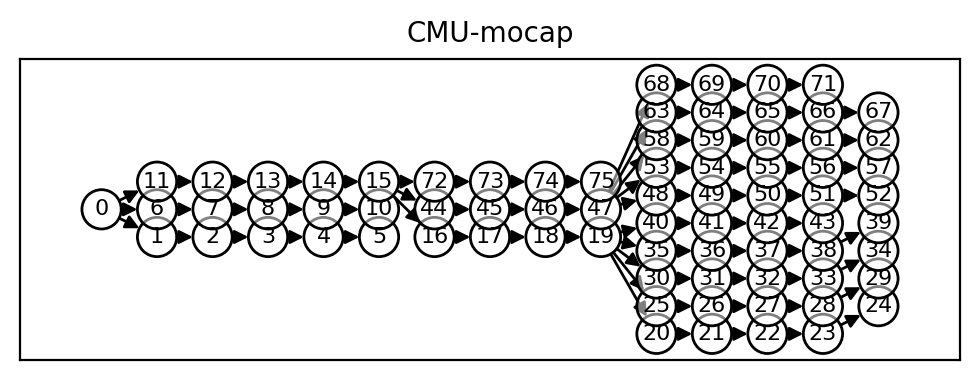

(307, 10, 3)


In [9]:
bvh_path  = "../data/bvh/VAAI_DIRECT_%s_a_M1.bvh" % data_number 
rpy_order = [2,0,1]
p_rate    = 0.01
skeleton  = get_skeleton_from_bvh(bvh_path)
print ("[%s] loaded. L:[%d]"%(bvh_path,skeleton.frames))
# Get `chains` from `skeleton`
secs,chains,hand_tip_pos = get_chains_from_skeleton_with_predicted_hands(
    skeleton=skeleton,
    env=env,
    predicted_hands=predicted_hands,
    rpy_order=rpy_order, # cmu:[2,1,0], nc:[2,0,1]
    p_rate=p_rate, # 0.1, 0.01
    PLOT_CHAIN_GRAPH=True,
    PLOT_INIT_CHAIN=False,
    VERBOSE=False,
)
print(hand_tip_pos.shape)
# Make `chains` z-up
chains_zup = get_chains_zup(
    chains,
    T_trans_zup = pr2t(np.array([0,0,0]),rpy2r(np.radians([0,0,90]))),
)

#### Animate `chians_zup`

In [10]:
predicted_hand_tip_pos = np.zeros_like(hand_tip_pos)
tip_pos = np.zeros((hand_tip_pos.shape[0], 12, 3))

env.init_viewer(
    viewer_title="Kinematic Chain",
    viewer_width=300,
    viewer_height=800,
    viewer_hide_menus=True,
)
env.update_viewer(
    azimuth=152,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2],
    VIS_TRANSPARENT=True,VIS_CONTACTPOINT=True,
    contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
    VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,
    jointrgba=[0.2,0.6,0.8,0.6],
)
env.reset()
tick,L = 0,len(chains_zup)
while tick < L:

    sim_time = secs[tick]
    chain = chains_zup[200]
    # Render
    chain.plot_chain_mujoco(
        env,
        r_link=0.01,
        rgba_link=(0.45, 0.25, 0.8, 0.5),
        PLOT_JOINT=False,PLOT_JOINT_AXIS=True,PLOT_JOINT_SPHERE=True,PLOT_JOINT_NAME=True,
        axis_len_joint=0.05,
        axis_width_joint=0.005,
        PLOT_REV_AXIS=False
    )
    for (i,n) in enumerate(hand_idx_names):
        tip_pos[tick,i,:] = np.array(chain.get_joint_p(joint_name=n))
        # print(chain.get_joint_p(joint_name=n))
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=0.25,axis_width=0.005)
    PLOT_TIME = False
    if PLOT_TIME:
        env.plot_T(p=np.array([0,0,1]),R=np.eye(3),PLOT_AXIS=False,
                   label="tick:[%d/%d] sim_time:[%.2f]sec"%(tick,L,sim_time))
    env.render()

    tick = tick + 1
    if (tick==L): tick = L-1
    
# Close viewer
env.close_viewer()
print ("Done.")

Pressed ESC
Quitting.


Exception: GLFW window does not exist but you tried to render.

## Repeat

In [ ]:
data_numbers = ["01_01","02_01","03_01","04_01","05_01","06_02","07_01","08_01","09_02","10_01",
                "11_01","12_02","13_01","14_01","15_02","16_02","17_01","18_01","19_01","20_01",
                "21_01","22_01","23_01","24_01","25_02","26_01","27_01"]

hand_idx_names = ['thumb_03_rEnd','index_03_rEnd','middle_03_rEnd','ring_03_rEnd','pinky_03_rEnd',
                  'thumb_03_lEnd','index_03_lEnd','middle_03_lEnd','ring_03_lEnd','pinky_03_lEnd']

l2_list = []

for data_number in data_numbers:
    body = np.load("../data/b2h_test/full_bodies%s.npy" % data_number[:2])
    body = body.reshape(body.shape[1],-1,3)

    predicted_hands = np.load("../data/b2h_test/predicted_hands%s.npy" % data_number[:2])
    predicted_hands = predicted_hands.reshape(predicted_hands.shape[1],-1,3)

    if predicted_hands.shape[0]!=body.shape[0]:
        temp = np.zeros((body.shape[0], predicted_hands.shape[1], predicted_hands.shape[2]))
        temp[:predicted_hands.shape[0], :, :] = predicted_hands
        temp[-1,:,:] = predicted_hands[-1,:,:]
        predicted_hands = temp

    for i in range(predicted_hands.shape[1]):
        for j in range(predicted_hands.shape[2]):
            predicted_hands[:,i,j] = gaussian_filter1d(predicted_hands[:,i,j], sigma=2)

    bvh_path  = "../data/bvh/VAAI_DIRECT_%s_a_M1.bvh" % data_number 
    rpy_order = [2,0,1]
    p_rate    = 0.01
    skeleton  = get_skeleton_from_bvh(bvh_path)
    print ("[%s] loaded. L:[%d]"%(bvh_path,skeleton.frames))
    # Get `chains` from `skeleton`
    secs,chains,hand_tip_pos = get_chains_from_skeleton_with_predicted_hands(
        skeleton=skeleton,
        env=env,
        predicted_hands=predicted_hands,
        rpy_order=rpy_order, # cmu:[2,1,0], nc:[2,0,1]
        p_rate=p_rate, # 0.1, 0.01
        PLOT_CHAIN_GRAPH=False,
        PLOT_INIT_CHAIN=False,
        VERBOSE=False,
    )

    # Make `chains` z-up
    chains_zup = get_chains_zup(
        chains,
        T_trans_zup = pr2t(np.array([0,0,0]),rpy2r(np.radians([0,0,90]))),
    )

    predicted_hand_tip_pos = np.zeros_like(hand_tip_pos)

    env.init_viewer(
        viewer_title="Kinematic Chain",
        viewer_width=1200,
        viewer_height=800,
        viewer_hide_menus=True,
    )
    env.update_viewer(
        azimuth=172,distance=5.6,elevation=-10,lookat=[0.0,-0.1,1.8],
        VIS_TRANSPARENT=True,VIS_CONTACTPOINT=True,
        contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
        VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,
        jointrgba=[0.2,0.6,0.8,0.6],
    )
    env.reset()
    tick,L = 0,len(chains_zup)
    while tick < L:

        sim_time = secs[tick]
        chain = chains_zup[tick]

        chain.plot_chain_mujoco(
            env,
            r_link=0.01,
            rgba_link=(0.45, 0.25, 0.8, 0.5),
            PLOT_JOINT=False,PLOT_JOINT_AXIS=True,PLOT_JOINT_SPHERE=True,PLOT_JOINT_NAME=True,
            axis_len_joint=0.05,
            axis_width_joint=0.005,
            PLOT_REV_AXIS=False
        )
        for (i,n) in enumerate(hand_idx_names):
            predicted_hand_tip_pos[tick,i,:] = np.array(chain.get_joint_p(joint_name=n))
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=0.25,axis_width=0.005)

        tick = tick + 1
        
    # Close viewer
    env.close_viewer()
    print ("Done.")

    a = np.load("../data/original/hand%s.npy" % data_number[:2]); b = predicted_hand_tip_pos
    diff = a - b
    dist = np.sqrt(diff[:,:,0]**2 + diff[:,:,1]**2 + diff[:,:,2]**2)
    l2_list.append(np.average(sum(dist)/L)*1000)
    print("%s L2 Distance (mm): %.4f" % (data_number[:2],np.average(sum(dist)/L)*1000))

Reading BVH file...
done
Building skeleton...
done
[../../bvh/nc_mocap/VAAI_DIRECT_01_01_a_M1.bvh] loaded. L:[116]
(116, 10, 3)
Done.
01 L2 Distance (mm): 43.1174
Reading BVH file...
done
Building skeleton...
done
[../../bvh/nc_mocap/VAAI_DIRECT_02_01_a_M1.bvh] loaded. L:[167]
(167, 10, 3)
Done.
02 L2 Distance (mm): 30.9676
Reading BVH file...
done
Building skeleton...
done
[../../bvh/nc_mocap/VAAI_DIRECT_03_01_a_M1.bvh] loaded. L:[273]
(273, 10, 3)
Done.
03 L2 Distance (mm): 49.4402
Reading BVH file...
done
Building skeleton...
done
[../../bvh/nc_mocap/VAAI_DIRECT_04_01_a_M1.bvh] loaded. L:[116]
(116, 10, 3)
Done.
04 L2 Distance (mm): 39.1413
Reading BVH file...
done
Building skeleton...
done
[../../bvh/nc_mocap/VAAI_DIRECT_05_01_a_M1.bvh] loaded. L:[239]
(239, 10, 3)
Done.
05 L2 Distance (mm): 46.9280
Reading BVH file...
done
Building skeleton...
done
[../../bvh/nc_mocap/VAAI_DIRECT_06_02_a_M1.bvh] loaded. L:[140]
(140, 10, 3)
Done.
06 L2 Distance (mm): 50.2552
Reading BVH file...
do

In [ ]:
l2_list = np.array(l2_list)
print("L2 Distance (mm): %.2f +/- %.2f" % (np.mean(l2_list), np.std(l2_list)))

L2 Distance (mm): 42.09 +/- 8.71


In [ ]:
data_numbers = ["01_01","02_01","03_01","04_01","05_01","06_02","07_01","08_01","09_02","10_01",
                "11_01","12_02","13_01","14_01","15_02","16_02","17_01","18_01","19_01","20_01",
                "21_01","22_01","23_01","24_01","25_02","26_01","27_01"]

hand_idx_names = ['thumb_03_rEnd','index_03_rEnd','middle_03_rEnd','ring_03_rEnd','pinky_03_rEnd',
                  'thumb_03_lEnd','index_03_lEnd','middle_03_lEnd','ring_03_lEnd','pinky_03_lEnd',
                  'hand_r','hand_l']

diversity_list = []

for data_number in data_numbers:
    body = np.load("../data/b2h_test/full_bodies%s.npy" % data_number[:2])
    body = body.reshape(body.shape[1],-1,3)

    predicted_hands = np.load("../data/b2h_test/predicted_hands%s.npy" % data_number[:2])
    predicted_hands = predicted_hands.reshape(predicted_hands.shape[1],-1,3)

    if predicted_hands.shape[0]!=body.shape[0]:
        temp = np.zeros((body.shape[0], predicted_hands.shape[1], predicted_hands.shape[2]))
        temp[:predicted_hands.shape[0], :, :] = predicted_hands
        temp[-1,:,:] = predicted_hands[-1,:,:]
        predicted_hands = temp

    for i in range(predicted_hands.shape[1]):
        for j in range(predicted_hands.shape[2]):
            predicted_hands[:,i,j] = gaussian_filter1d(predicted_hands[:,i,j], sigma=2)

    bvh_path  = "../data/bvh/VAAI_DIRECT_%s_a_M1.bvh" % data_number 
    rpy_order = [2,0,1]
    p_rate    = 0.01
    skeleton  = get_skeleton_from_bvh(bvh_path)
    print ("[%s] loaded. L:[%d]"%(bvh_path,skeleton.frames))
    # Get `chains` from `skeleton`
    secs,chains,hand_tip_pos = get_chains_from_skeleton_with_predicted_hands(
        skeleton=skeleton,
        env=env,
        predicted_hands=predicted_hands,
        rpy_order=rpy_order, # cmu:[2,1,0], nc:[2,0,1]
        p_rate=p_rate, # 0.1, 0.01
        PLOT_CHAIN_GRAPH=False,
        PLOT_INIT_CHAIN=False,
        VERBOSE=False,
    )

    # Make `chains` z-up
    chains_zup = get_chains_zup(
        chains,
        T_trans_zup = pr2t(np.array([0,0,0]),rpy2r(np.radians([0,0,90]))),
    )

    predicted_hand_tip_pos = np.zeros_like(hand_tip_pos)
    tip_pos = np.zeros((hand_tip_pos.shape[0], 12, 3))

    env.init_viewer(
        viewer_title="Kinematic Chain",
        viewer_width=300,
        viewer_height=800,
        viewer_hide_menus=True,
    )
    env.update_viewer(
        azimuth=152,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2],
        VIS_TRANSPARENT=True,VIS_CONTACTPOINT=True,
        contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
        VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,
        jointrgba=[0.2,0.6,0.8,0.6],
    )
    env.reset()
    tick,L = 0,len(chains_zup)
    while tick < L:

        sim_time = secs[tick]
        chain = chains_zup[tick]
        # Render
        chain.plot_chain_mujoco(
            env,
            r_link=0.01,
            rgba_link=(0.45, 0.25, 0.8, 0.5),
            PLOT_JOINT=False,PLOT_JOINT_AXIS=True,PLOT_JOINT_SPHERE=True,PLOT_JOINT_NAME=True,
            axis_len_joint=0.05,
            axis_width_joint=0.005,
            PLOT_REV_AXIS=False
        )
        for (i,n) in enumerate(hand_idx_names):
            tip_pos[tick,i,:] = np.array(chain.get_joint_p(joint_name=n))

        tick = tick + 1
        
    # Close viewer
    env.close_viewer()

    wrist_dist = np.zeros((tip_pos.shape[0],10))

    for i in range(0,5):
        wrist_dist[:,i] = np.linalg.norm(tip_pos[:,i,:] - tip_pos[:,10,:], axis=1)
    for i in range(5,10):
        wrist_dist[:,i] = np.linalg.norm(tip_pos[:,i,:] - tip_pos[:,11,:], axis=1)

    num = np.int64(np.ceil(tip_pos.shape[0]/64))
    split_dist = np.zeros((num, 64, 10))
    for i in range(0,num-1):
        split_dist[i,:,:] = wrist_dist[i*64:(i+1)*64,:]
    split_dist[num-1,:,:] = wrist_dist[-64:,:]

    k = 0
    sum = np.zeros((64,10))
    for i in range(0,num):
        for j in range(i+1,num):
            k += 1
            sum += np.abs(split_dist[i,:,:] - split_dist[j,:,:])

    avg = np.sum(sum/k)
    diversity_list.append(avg)
    print(avg)

Reading BVH file...
done
Building skeleton...
done
[../../bvh/nc_mocap/VAAI_DIRECT_01_01_a_M1.bvh] loaded. L:[116]
0.32421478325828784
Reading BVH file...
done
Building skeleton...
done
[../../bvh/nc_mocap/VAAI_DIRECT_02_01_a_M1.bvh] loaded. L:[167]
0.055967443504771015
Reading BVH file...
done
Building skeleton...
done
[../../bvh/nc_mocap/VAAI_DIRECT_03_01_a_M1.bvh] loaded. L:[273]
0.20666348255245393
Reading BVH file...
done
Building skeleton...
done
[../../bvh/nc_mocap/VAAI_DIRECT_04_01_a_M1.bvh] loaded. L:[116]
0.029604899320161845
Reading BVH file...
done
Building skeleton...
done
[../../bvh/nc_mocap/VAAI_DIRECT_05_01_a_M1.bvh] loaded. L:[239]
0.022091532981997633
Reading BVH file...
done
Building skeleton...
done
[../../bvh/nc_mocap/VAAI_DIRECT_06_02_a_M1.bvh] loaded. L:[140]
0.01636887535752076
Reading BVH file...
done
Building skeleton...
done
[../../bvh/nc_mocap/VAAI_DIRECT_07_01_a_M1.bvh] loaded. L:[230]
0.016194280756646365
Reading BVH file...
done
Building skeleton...
done


In [ ]:
diversity_list = np.array(diversity_list)
print("Diversity: %.2f +/- %.2f" % (np.mean(diversity_list), np.std(diversity_list)))

Diversity: 0.11 +/- 0.09
